In [0]:
import os
import re
import math
import numpy as np
import pandas as pd
import seaborn as sn
import random 
import csv
from matplotlib import pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
#training googlenews model
filename = 'drive/My Drive/ML Project/folder/GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
#testing model
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.7118192911148071)]


In [0]:
def cleanData (Data):

    string = "!@&*~`<>#$,.?-_/\*%=+|;:(){}1234567890"
    stopwords = np.loadtxt('drive/My Drive/ML Project/stopwords.txt',dtype='str')
    #clean all the tweets one by one
    for i in range(Data.shape[0]):
        
        row = Data.iloc[i,1]
        #print(row)
        row = row.lower()
        #delete all the characters in string
        for char in string:
            row = row.replace(char," ")
        row = row.replace('"'," ")
        row = row.replace('“'," ")
        row = row.replace('”'," ")
        row = row.replace("'"," ")
        #removing all stop words
        headline = row.split()
        resultwords  = [word for word in headline if word.lower() not in stopwords]
        row = ' '.join(resultwords)
        #print(row)
        #print("*******************************************************************")

        #saving cleaned data to headline column
        Data.iloc[i,1] = row

    return Data

In [0]:
df = pd.read_csv('drive/My Drive/ML Project/train.txt',sep='\t')

In [0]:
df= df.astype('str')
Data = pd.DataFrame(data=np.empty((df.shape[0])),columns=['empty'])

In [0]:
Data['labels'] = df.iloc[:,0].str[0]
Data['headlines'] = df.iloc[:,0].str[2:]

In [0]:
Data.head(2)

,empty,labels,headlines
0,0.000000e+00,1,increasingly paranoid campbell's begins stockp...
1,6.921237e-310,1,monster truck escapes


In [0]:
Data = Data.drop('empty',axis=1)

In [0]:
Data.head(5)

,labels,headlines
0,1,increasingly paranoid campbell's begins stockp...
1,1,monster truck escapes
2,0,sunday roundup
3,1,birthday card for david axelrod circling aroun...
4,0,morocco cracks down on journalists


In [0]:
cleanedData = cleanData(Data)
cleanedData.head(5)

,labels,headlines
0,1,increasingly paranoid campbell s begins stockp...
1,1,monster truck escapes
2,0,sunday roundup
3,1,birthday card david axelrod circling around af...
4,0,morocco cracks journalists


In [0]:
#return processed data and indexes of headlines with no word in model
def preprocessing(Data):

  X = pd.DataFrame(data=np.zeros((Data.shape[0],300)))
  mean = 0
  count = 0
  indexes = []

  for x in range(Data.shape[0]):

    headline = Data.iloc[x,1]
    words = headline.split()
    mean =0
    for word in words:
      try:
        value = model[word]
      except:
        value = 0
      mean = mean + value
    try:
      if mean == 0:
        count+=1
        indexes.append(x)
    except:
      pass
    X.iloc[x,:] = mean
  print('No of headlines with no word in model=',count)

  return X, indexes
  

In [0]:
#return processed data and indexes of headlines with no word in model
X, indexes = preprocessing(cleanedData)
print(X.shape)
print(len(indexes))

No of headlines with no word in model= 3
(22891, 300)
3


In [0]:
#removing 3 headlines which are not in our model
print(cleanedData.iloc[indexes[0],1])
print(cleanedData.iloc[indexes[1],1])
print(cleanedData.iloc[indexes[2],1])
cleanedData = cleanedData.drop(cleanedData.index[[indexes[0],indexes[1],indexes[2]]])
print(cleanedData.iloc[indexes[0],1])
print(cleanedData.iloc[indexes[1],1])
print(cleanedData.iloc[indexes[2],1])

yazidi
charlottesville

ncis cease print edition
genetics emphatically deny playing part area man s body
bakery s closing nets man ton free éclairs


In [0]:
#removing 3 headlines vector from X, which are not in our model
print(sum(X.iloc[indexes[0],:]))
print(sum(X.iloc[indexes[1],:]))
print(sum(X.iloc[indexes[2],:]))
X = X.drop(X.index[[indexes[0],indexes[1],indexes[2]]])
print(sum(X.iloc[indexes[0],:]))
print(sum(X.iloc[indexes[1],:]))
print(sum(X.iloc[indexes[2],:]))

0.0
0.0
0.0
9.010892868041992
-2.6740379333496094
-15.83795690536499


In [0]:
Y = cleanedData.loc[:,'labels']


In [0]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.073730,0.819702,0.252075,1.294189,-0.733063,0.781006,-0.676331,-0.635437,1.281738,0.150269,-0.556702,-0.977058,-0.007874,0.946518,-1.371506,0.800049,-0.151611,0.861572,0.397156,-1.469482,-0.215820,0.082031,0.322083,0.247513,1.438721,0.104889,0.517090,-0.237793,-0.266602,0.517532,0.338470,0.480408,-1.259338,-0.444901,-0.639832,0.441223,-0.579590,0.268524,0.743774,0.410889,...,0.060181,0.392822,-0.606445,-0.326782,-0.109619,1.292480,-0.783981,-0.012360,-0.480957,-0.442261,-0.161865,1.127319,1.572723,0.738037,0.720703,-0.647461,-0.390747,0.391357,0.348877,1.662750,0.243042,-0.150391,0.523254,-0.109436,0.027939,0.186218,-0.837662,0.178467,0.909271,0.561279,-0.433594,-0.712891,-0.706543,0.972290,-0.225098,-1.926758,-0.140869,0.036255,0.759980,0.978638
1,0.316406,0.380737,-0.422073,0.101318,0.222900,-0.194336,-0.197998,-0.382568,0.574707,0.073730,0.060303,-0.641602,0.151855,-0.441162,-0.246338,0.011719,-0.295532,0.295654,0.266113,-0.303589,0.242188,0.208008,-0.020020,0.389648,0.584961,-0.567139,-0.004883,0.304810,0.610352,-0.301270,0.071533,-0.268066,-0.120117,0.559570,-0.498230,-0.041504,0.550537,0.183685,-0.103760,0.163086,...,-0.086243,-0.163574,-0.315186,0.344177,0.314941,0.227051,-0.502930,0.473495,-0.388672,0.456543,-0.318909,-0.166016,0.284180,0.010498,0.037842,-0.016968,-0.122681,-0.159180,0.197632,0.217285,-0.187744,-0.140747,0.043015,-0.188232,0.095459,-0.134232,-0.264648,-0.118179,-0.028687,0.057617,-0.585938,-0.046143,-0.410400,0.281738,-0.588379,-0.169434,-0.367065,-0.240234,-0.251373,-0.262695
2,-0.216309,0.288651,-0.267090,0.143982,0.218750,-0.507080,-0.018311,-0.373047,0.081299,0.385742,-0.666992,-0.340820,-0.394043,-0.013672,-0.078369,0.005859,-0.370361,0.162354,0.549805,-0.647461,0.438477,0.190796,0.055664,-0.016113,-0.222656,0.096191,0.222656,0.419434,-0.158447,0.005127,0.110596,0.081787,0.325684,-0.326172,0.084473,0.398438,-0.294922,-0.199585,0.560547,0.463379,...,0.208130,-0.013672,0.369629,0.052246,-0.022949,0.243652,-0.085938,0.139404,-0.125488,0.484863,-0.309082,0.190918,0.238770,0.326660,0.340820,-0.398926,0.064331,-0.344727,-0.112183,0.683594,-0.034668,0.018646,0.088989,0.720703,-0.108032,-0.514648,-0.312622,0.557617,-0.038086,-0.035156,0.653320,-0.248779,0.076172,0.479980,-0.031128,0.017578,-0.414307,-0.164062,-0.317383,0.365112
3,-0.564453,0.799683,-0.086670,1.522217,-0.766113,-0.355713,0.226318,-1.685791,0.572998,0.652588,0.109283,-1.041992,-0.635254,0.028015,-0.418213,-0.066315,-0.526123,0.835938,-0.039429,-1.208008,0.384216,0.934723,0.574463,-0.406128,-0.095947,0.386963,-1.354614,0.509766,0.696777,-0.920105,-0.001953,-0.420389,-0.094330,-0.745209,-0.384033,-0.104614,0.594635,-0.106934,-0.009399,0.062775,...,-0.821411,-0.194077,-0.160828,-1.133301,-0.794678,0.538818,-0.021118,0.099426,-0.757812,0.235046,0.105062,0.115723,0.385010,0.176025,1.259766,-0.680542,-0.264282,-0.568237,-1.536865,0.689087,-0.199463,-0.154068,-0.454834,0.665955,-0.249146,0.335571,-0.607300,0.548279,0.766980,0.477554,-0.721863,0.067627,-0.603027,0.523926,0.160767,-1.221191,-0.605042,0.078766,-0.946289,0.568359
4,-0.149399,0.291626,-0.256714,0.146240,-0.306000,-0.014526,-0.152313,-0.293701,0.109009,0.254883,-0.227051,-0.125671,0.036865,0.187012,-0.536133,-0.082581,0.090332,0.226562,-0.421875,-0.052948,0.590088,-0.078613,0.124512,-0.386963,0.593750,-0.455261,0.219360,0.375000,0.173828,-0.548279,-0.677734,-0.073975,-0.174805,0.323242,0.000488,-0.111572,-0.056519,0.644531,0.023193,0.230804,...,-0.130249,-0.027832,0.267975,-0.099609,-0.189209,0.381836,-0.186279,-0.221436,-0.261963,-0.155151,-0.139984,0.506836,0.316589,0.071970,0.393066,0.046875,0.441772,-0.383530,-0.238770,0.376465,-0.231934,-0.442631,0.384766,0.206543,0.304443,-0.811523,-0.498047,0.506836,-0.092

In [0]:
X = X.to_numpy()
Y = Y.to_numpy()
Y = Y.astype(int)
Y.dtype

dtype('int64')

In [0]:
print(Y[0:10])

[1 1 0 1 0 0 1 1 0 1]


In [0]:
df = pd.read_csv('drive/My Drive/ML Project/test.txt',sep='\t')

In [0]:
df= df.astype('str')
Data = pd.DataFrame(data=np.empty((df.shape[0])),columns=['empty'])

In [0]:
Data['labels'] = df.iloc[:,0].str[0]
Data['headlines'] = df.iloc[:,0].str[2:]

In [0]:
Data.head(2)

,empty,labels,headlines
0,0.000000e+00,0,"an open letter to editors rejecting #metoo, #m..."
1,6.921192e-310,1,group of christie campaign deserters found in ...


In [0]:
Data = Data.drop('empty',axis=1)

In [0]:
Data.head(5)

,labels,headlines
0,0,"an open letter to editors rejecting #metoo, #m..."
1,1,group of christie campaign deserters found in ...
2,0,noose found in african-american history museum...
3,1,democratic congressman protests trump's enviro...
4,0,rex tillerson calls reports of his ouster 'lau...


In [0]:
testData = cleanData(Data)

In [0]:
testData.head(5)

,labels,headlines
0,0,open letter editors rejecting metoo meat submi...
1,1,group christie campaign deserters found forest
2,0,noose found african american history museum ex...
3,1,democratic congressman protests trump s enviro...
4,0,rex tillerson calls reports ouster laughable


In [0]:
#return processed data and indexes of headlines with no word in model
X_test, indexes = preprocessing(testData)
print(X_test.shape)
print(len(indexes))

No of headlines with no word in model= 0
(5723, 300)
0


In [0]:
Y_test = testData.loc[:,'labels']
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-1.112793,0.780029,0.455811,0.773682,0.039185,0.215210,0.074402,0.212738,0.817383,0.838867,-0.032227,-0.616882,-0.118103,0.157471,-0.435974,-0.208618,0.300903,-0.005371,-0.118973,-0.436371,1.641113,0.687256,-0.181030,-0.256836,0.750366,-0.671387,-0.129272,0.160278,0.532288,-0.926361,-0.078491,-0.885498,-0.621826,0.164429,0.332764,0.255859,0.661987,0.961792,-0.218018,0.769287,...,0.018028,-0.211670,-0.535278,-0.482239,0.120361,0.224365,-0.651489,0.420685,-0.646729,-0.746338,0.302979,1.027100,0.483215,-0.176514,0.428345,-0.668945,-0.528748,-0.209900,0.266418,1.190430,-0.124023,-0.069092,-0.208344,0.412598,0.354492,0.668030,0.125977,1.134766,0.370728,0.572144,-0.314667,-0.791748,-0.379883,1.155762,0.494080,0.300537,0.562561,-0.772583,-0.414795,0.691650
1,0.704102,0.338440,-0.088043,0.130981,0.600811,-0.598633,-0.385010,-0.323828,0.222122,-0.048828,0.437500,-0.752441,-0.763672,0.200562,-0.635498,0.007690,0.316284,0.204834,-0.895203,0.090317,0.293335,-0.046265,-0.405273,-0.188354,-0.280029,-1.048950,-0.690002,0.282471,0.400558,-0.228981,0.452637,-0.053329,-0.500977,-0.116272,-0.317017,-0.705933,-0.006088,-0.331055,0.645020,-0.031677,...,0.206177,-0.295654,0.515854,0.492676,-0.035034,-0.212646,-1.162292,-0.244873,-0.569824,-0.025391,0.618042,0.238770,0.489990,-0.134521,0.133118,-0.053223,0.061035,-0.335180,0.073486,0.233276,-0.036133,-0.684326,0.433838,0.152161,-0.083130,-0.684692,-0.920166,0.236450,0.718506,0.424561,-0.377930,-0.047363,-0.583496,-0.127228,-0.168091,-0.421387,0.439209,-0.144379,0.791382,0.365540
2,-0.220215,1.229004,0.310913,1.768066,-0.280273,-0.634094,0.148682,-0.867163,0.567627,-0.423828,0.231720,-1.950684,-1.410400,0.058472,-0.809570,0.268921,-0.577515,1.371338,-0.315674,-0.523438,0.056030,-0.620117,0.173988,-1.152908,-0.953384,0.159851,-2.281982,0.570312,0.327866,-0.204079,0.267822,0.098480,-1.051025,-0.138062,-0.007385,0.194824,-0.482895,0.886230,0.475708,0.537613,...,-0.230957,0.182745,0.146484,0.280396,0.056885,1.218689,0.715347,-0.534851,-1.497498,-0.647705,-0.343719,0.656250,0.109009,0.257385,1.064758,-0.669250,-1.190918,-0.305420,-0.795410,0.575439,0.806274,1.077515,-0.174744,0.546387,-1.460144,0.169556,-0.326172,0.687378,0.866943,-0.736816,-0.870361,0.158844,-0.388428,1.505493,-0.430908,-0.593018,-0.137207,-0.065277,-0.132751,-0.126831
3,-0.460495,0.960876,0.474609,1.914612,-0.471741,-1.516251,-0.466263,-0.202026,1.495361,0.725769,-0.024559,-1.408997,-0.213440,0.124939,-1.322021,0.587769,0.429932,1.172485,-0.380981,-1.040771,0.501831,0.220215,0.456909,0.303772,-0.681274,0.091736,-1.321869,-0.466980,1.772461,-0.426208,0.851898,-0.291260,-2.051270,1.538696,0.679382,-0.830322,1.382278,1.021851,0.757233,1.598877,...,-0.624252,-0.104004,0.681213,1.674805,1.634033,1.262512,-1.766602,-0.261185,-1.568848,-0.537323,-0.358978,0.681274,-0.558777,0.260132,-0.604980,-1.306702,-0.208801,-1.509399,-1.819580,0.596619,-0.349731,0.139893,1.188721,1.613647,-0.378708,-0.753395,-1.018738,-0.440735,1.644531,-0.495605,-0.433350,-1.399902,-1.244823,0.199219,1.128784,-0.080750,0.847412,-0.405518,1.558411,2.097168
4,-0.460938,0.085632,-0.272705,-0.189941,-0.072021,-0.117081,0.158081,-0.726074,0.934082,0.249512,-0.253174,-0.492432,-0.233398,0.087036,0.198486,1.014038,0.193872,-0.141113,-0.408813,-0.433533,0.558655,-0.030396,0.416504,-0.301270,-0.409180,-0.273331,-0.986816,0.327393,0.171692,-0.057373,-0.205566,-0.067749,-0.613403,-0.364258,0.126801,0.491699,0.032532,0.872070,0.343109,0.912842,...,0.387939,0.747559,0.082764,1.142822,0.121094,0.526062,-0.579102,-0.485596,-0.325287,-0.320190,-0.317139,0.629883,0.609955,-0.645020,0.107910,-0.156754,-0.174988,0.126953,0.034668,0.833697,-0.240234,-0.219727,-0.056152,0.136017,0.194824,-0.472412,-0.363770,0.062317,0.0

In [0]:
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()
Y_test = Y_test.astype(float)
Y_test.dtype

dtype('float64')

In [0]:
#computes distance of point from whole dataset
def cosine_similarity (testdataset, traindataset):

  similaritymatrix = np.dot(testdataset,traindataset.T)
  print(similaritymatrix.shape)
  Asqr = np.square(testdataset)
  A = np.sum(Asqr,axis=1)
  A = np.sqrt(A)
  print(A.shape)
  Bsqr = np.square(traindataset)
  B = np.sum(Bsqr,axis=1)
  B = np.sqrt(B)
  print(B.shape)

  for x in range(testdataset.shape[0]):
    print(x)
    for y in range(traindataset.shape[0]):

      similaritymatrix[x,y] = similaritymatrix[x,y]/(A[x]*B[y])

  print(similaritymatrix.shape)
  return similaritymatrix

In [0]:
similaritymatrix = cosine_similarity(X_test,X)
print(similaritymatrix.shape)
cosine_distance = 1 - similaritymatrix
print(cosine_distance.shape)

Streaming output truncated to the last 5000 lines.
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
9

In [0]:
#predicts class of the testdata from traindata on base of k nearest neighbours 
def predict(testdata,Ytrain,k,similaritymatrix):

  testclass = []

  for x in range(testdata.shape[0]):

    distances = similaritymatrix[x,:]
    #print(distances.shape)
    #sorting array of distances to get k nearest neighbours
    sortedDis = np.argsort(distances,axis=0, kind='quicksort')
    classes = np.zeros((2,1))

    for i in range(k):

      #getting indexes of k nearest neighbours
      index = sortedDis[i]
      #print('index =', index)
      Sd_index = index
      #print(distances[index])
      #print(Sd_index)
      #counting frequency of classes of neighbors, to determine most frequent class
      if (Ytrain[Sd_index] == 0):
        classes[0] += 1

      if (Ytrain[Sd_index] == 1):
        classes[1] += 1

    #incase of tie, try again with k-1 neighbors
    if(classes[0]==classes[1]):

      classes[0] =0
      classes[1] =0

      for i in range(k):

        #getting indexes of k-1 nearest neighbours from current point 
        index = sortedDis[i]
        Sd_index = index
        #print(Sd_index)
        #counting frequency of classes of neighbors, to determine most frequent class
        if (Ytrain[Sd_index] == 0):
          classes[0] += 1

        if (Ytrain[Sd_index] == 1):
          classes[1] += 1
      
    #assigning class to the point with highest no of nearest neighbours
    if (classes.argmax() == 0):
      finalclass = 0
      print(finalclass)

    if (classes.argmax() == 1):
      finalclass = 1
      print(finalclass)

    testclass.append(finalclass)
    print('point =', x)

  return testclass


In [0]:
k=10
print(cosine_distance.shape)
testclass = predict(X_test,Y, k, cosine_distance )

Streaming output truncated to the last 5000 lines.
point = 3223
1
point = 3224
1
point = 3225
0
point = 3226
0
point = 3227
0
point = 3228
0
point = 3229
0
point = 3230
0
point = 3231
0
point = 3232
1
point = 3233
0
point = 3234
0
point = 3235
1
point = 3236
0
point = 3237
1
point = 3238
0
point = 3239
1
point = 3240
1
point = 3241
0
point = 3242
1
point = 3243
1
point = 3244
1
point = 3245
0
point = 3246
1
point = 3247
1
point = 3248
0
point = 3249
1
point = 3250
0
point = 3251
0
point = 3252
0
point = 3253
0
point = 3254
0
point = 3255
0
point = 3256
0
point = 3257
0
point = 3258
0
point = 3259
0
point = 3260
0
point = 3261
0
point = 3262
0
point = 3263
0
point = 3264
0
point = 3265
0
point = 3266
0
point = 3267
0
point = 3268
0
point = 3269
0
point = 3270
0
point = 3271
1
point = 3272
1
point = 3273
0
point = 3274
0
point = 3275
1
point = 3276
0
point = 3277
1
point = 3278
1
point = 3279
0
point = 3280
0
point = 3281
1
point = 3282
1
point = 3283
0
point = 3284
0
point = 3285
0
poin

In [0]:
#computes accuracy of the result by comparing predicted class from actual class of each point
def result (testdata,Ytest,testclass):

  true = 0
  false = 0

  for x in range(testdata.shape[0]):

    if(testclass[x] == Ytest[x]):
      true += 1
    else:
      #print(testclass[x],Ytest[x])
      false += 1

  accuracy = true / (true+false)*100
  
  return accuracy 

In [0]:
#creates confusion matrix from actual and predicted tags and value of precision, recall etc
def confusionMatrix (my_Y, Y):

    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for i in range(np.size(my_Y)):

        if(Y[i] == 1):
            if(my_Y[i] == 1):
                TP +=1

        if(Y[i] == 1):
            if(my_Y[i] == 0):
                FN+=1

        if(Y[i] == 0):
            if(my_Y[i] == 0):
                TN+=1

        if(Y[i] == 0):
            if(my_Y[i] == 1):
                FP+=1

    ConfMatrix = [[TP,FP],
                  [FN,TN]]
    print('Confusion Matrix:\n',ConfMatrix)

    Accuracy = (TP+TN)/(TP+TN+FN+FP)
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1 = (2*(Precision*Recall))/(Precision+Recall)

    df_cm = pd.DataFrame(ConfMatrix, index = [i for i in "10"],
                  columns = [i for i in "10"])
    plt.figure(figsize = (5,5))
    sn.heatmap(df_cm, annot=True)
    
    
    print('Accuracy = ', Accuracy)
    print('Precision = ', Precision)
    print('Recall = ', Recall)
    print('F1 score = ', F1)

    return 

Accuracy of classification for k = 1 is 71.81548139087892 %
Confusion Matrix:
 [[1900, 786], [827, 2210]]
Accuracy =  0.7181548139087891
Precision =  0.7073715562174236
Recall =  0.6967363403006968
F1 score =  0.7020136707925365


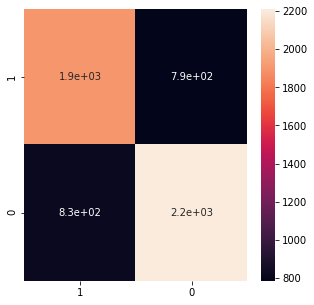

In [0]:
accuracy = result(testData,Y_test,testclass)

print('Accuracy of classification for k =',k, 'is', accuracy,'%')
confusionMatrix(testclass, Y_test)

Accuracy of classification for k = 3 is 74.31417088939367 %
Confusion Matrix:
 [[1951, 694], [776, 2302]]
Accuracy =  0.7431417088939367
Precision =  0.7376181474480151
Recall =  0.7154382104877154
F1 score =  0.7263588979895755


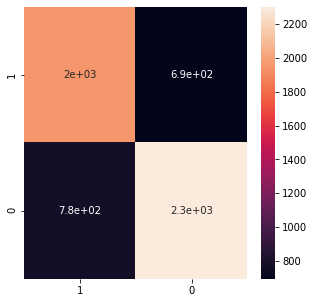

In [0]:
accuracy = result(testData,Y_test,testclass)

print('Accuracy of classification for k =',k, 'is', accuracy,'%')
confusionMatrix(testclass, Y_test)

Accuracy of classification for k = 5 is 75.53730560894635 %
Confusion Matrix:
 [[1987, 660], [740, 2336]]
Accuracy =  0.7553730560894636
Precision =  0.7506611258027956
Recall =  0.7286395306197286
F1 score =  0.7394864160774097


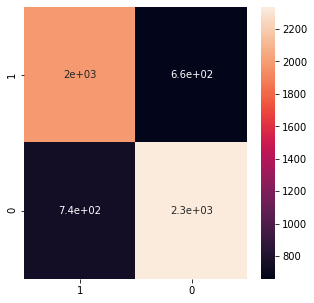

In [0]:
accuracy = result(testData,Y_test,testclass)

print('Accuracy of classification for k =',k, 'is', accuracy,'%')
confusionMatrix(testclass, Y_test)

Accuracy of classification for k = 7 is 76.1488729687227 %
Confusion Matrix:
 [[2002, 640], [725, 2356]]
Accuracy =  0.761488729687227
Precision =  0.7577592732778198
Recall =  0.7341400806747341
F1 score =  0.7457627118644068


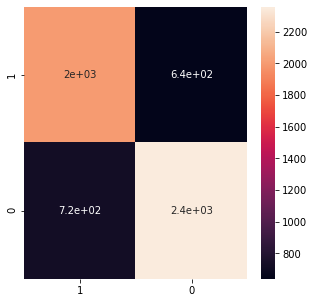

In [0]:
accuracy = result(testData,Y_test,testclass)

print('Accuracy of classification for k =',k, 'is', accuracy,'%')
confusionMatrix(testclass, Y_test)

Accuracy of classification for k = 10 is 75.34509872444522 %
Confusion Matrix:
 [[1813, 497], [914, 2499]]
Accuracy =  0.7534509872444523
Precision =  0.7848484848484848
Recall =  0.6648331499816649
F1 score =  0.7198729402422076


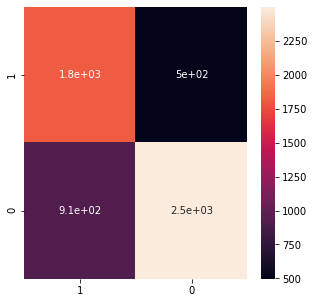

In [0]:
accuracy = result(testData,Y_test,testclass)

print('Accuracy of classification for k =',k, 'is', accuracy,'%')
confusionMatrix(testclass, Y_test)